In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from cam_class_optimization import CamGeneration
import pandas as pd
import plotly.express as px

In [2]:
class multi_objective_mechanism_optimization(Problem):
    
    # When intializing get the mechanism structure which is being optimized
    # (not the initial positions as we are trying to find those)
    def __init__(self,gear_ratios,initial_gear_ratio,percentages,target_peak_force,target_percentage_max):
        
        xl = 0.05 * np.ones(9)
        xu = 1.5 * np.ones(9)

        super().__init__(n_var = (gear_ratios.shape[1]) + 1, n_obj=4, xl=xl, xu=xu, elementwise_evaluation=True)
        
        # Store mechanism information for later 
        self.gear_ratios = gear_ratios
        self.initial_gear_ratio = initial_gear_ratio
        self.target_peak_force = target_peak_force
        self.target_percentage_max = target_percentage_max
        self.percentages = percentages
        
    def _evaluate(self, x, out, *args, **kwargs):
        
        objective_dict = {1:np.zeros(x.shape[0]),2:np.zeros(x.shape[0]),3:np.zeros(x.shape[0]),4:np.zeros(x.shape[0])}
        for i,sub_x in enumerate(x):
            # x is an array of <pop_size> arrays of gear ratios (and not percentages)
            gear_ratios = sub_x[:-1] # grabs all of the gear ratios except for the last one
            gear_ratios = np.hstack((gear_ratios,self.percentages))
            gear_ratios= gear_ratios.reshape((2,-1))
            gear_ratios[1,0] = 0
            gear_ratios[1, :] = 2 * np.pi * gear_ratios[1, :]
            
            initial_gr = sub_x[-1]
            filename = 'data/Knee-angle_Chugo_2006.csv'
            Cam = CamGeneration(gear_ratios.T, initial_gr, sit_angle = np.pi * 220 / 180) # create Cam object given input gear ratios
            max_radius = Cam.calculate_cam_radii() # get maximum radius from generated cams
            forces,percentages = Cam.plot_forces_percentage(filename, torque = False, stroke = 0.1, plot = False) # get forces from generated cams
            ideal_perc_ind = np.where(np.round(percentages,1) == 32.3)[0][0] 
            ideal_perc_force = forces[ideal_perc_ind] # get magnitude of force at the stance percentage where max force is ideally timed
            max_force = max(forces)
            max_force_perc = percentages[np.where(forces == max_force)[0][0]] # get stance percentage where max force actually occurs
            sitting_perc_ind = np.where(np.round(percentages,1) == 0)[0][0]
            sitting_force = forces[sitting_perc_ind] # get actual forces at 0% stance (sitting)    

            objective_dict[1][i] = max_radius
            objective_dict[2][i] = abs(max_force_perc - self.target_percentage_max)
            objective_dict[3][i] = abs(max_force - self.target_peak_force)
            objective_dict[4][i] = abs(sitting_force)

        out["F"] = [objective_dict[1],objective_dict[2],objective_dict[3],objective_dict[4]] # size, max_force_perc, max_force_diff, sitting_force

In [14]:
gr0 = np.array( [ [0.18, 0.18, 6.00, 0.50, 1.40, 1.70, 1.50, 0.90],
                  [0.00, 0.08, 0.28, 0.40, 0.45, 0.50, 0.60, 0.66] ] )
gr0[1, :] = 2 * np.pi * gr0[1, :] # convert from percentages into radians
gear_percentages = np.array([0  , .08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.66])

initial_gear_ratio=0.5

pop_size = 50
generations = 100

# Setup and instance of our problem
problem = multi_objective_mechanism_optimization(gear_ratios = gr0,
                                                initial_gear_ratio = initial_gear_ratio,
                                                percentages = gear_percentages,
                                                target_peak_force = 175,
                                                target_percentage_max = 32.5)
# Set up Algorithm
algorithm = NSGA2(
    pop_size = pop_size,
    n_offsprings = pop_size,
    sampling = FloatRandomSampling(),
    crossover = SBX(prob = 0.9, eta = 15),
    mutation = PM(eta = 20),
    eliminate_duplicates = True
)
termination = get_termination("n_gen", generations)
results = minimize(problem,
                   algorithm,
                   termination,
                   verbose = True,
                   save_history = True,
                   seed = 3)
X = results.X # design space values (decision variables)
F = results.F # objective space values



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |     10 |             - |             -
     2 |      100 |     20 |  0.0474148279 |         ideal
     3 |      150 |     26 |  0.0894399758 |         ideal
     4 |      200 |     32 |  0.0093078240 |         ideal
     5 |      250 |     42 |  0.0980371277 |         ideal
     6 |      300 |     47 |  0.0099502488 |         ideal
     7 |      350 |     50 |  0.0264861267 |         ideal
     8 |      400 |     50 |  0.0098973308 |         ideal
     9 |      450 |     50 |  0.0254297595 |         ideal
    10 |      500 |     50 |  0.0291418866 |             f
    11 |      550 |     50 |  0.2237626456 |         nadir
    12 |      600 |     50 |  0.0221840272 |         nadir
    13 |      650 |     50 |  0.0238051033 |             f
    14 |      700 |     50 |  0.0097788247 |         ideal
    15 |      750 |     50 |  0.0236125531 |             f
    16 |      800 |     50 |  0.3354651943 |         nad

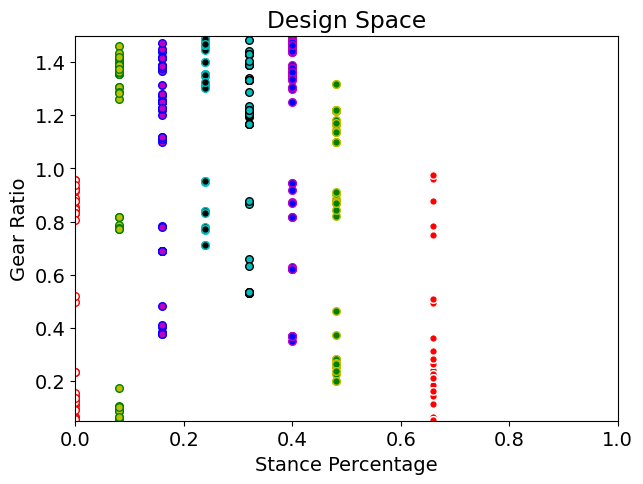

In [15]:
percent_array = np.zeros_like(X[:,:8])
for i, elem in enumerate(percent_array):
    percent_array[i] = gear_percentages
xl, xu = problem.bounds()

plt.figure(figsize=(7, 5))
colors = ['r','g','b','c','k','m','y','w']
for i in range(8):
    plt.scatter(percent_array[:,i], X[:, i], s=30, facecolors=colors[7-i], edgecolors=colors[i])
plt.xlim(0, 1)
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.xlabel("Stance Percentage")
plt.ylabel("Gear Ratio")
plt.show()

df_dict = {'Size':F[:,0],'ideal_m_f_perc_diff':F[:,1],'ideal_max_force_diff':F[:,2],'sitting_force':F[:,3]}
df = pd.DataFrame(data=df_dict)
fig = px.scatter_3d(df, x='ideal_m_f_perc_diff', y='ideal_max_force_diff', z='sitting_force', color='Size')
fig.show()

There are 50 results in the pareto front!
New solution! This is index 7!


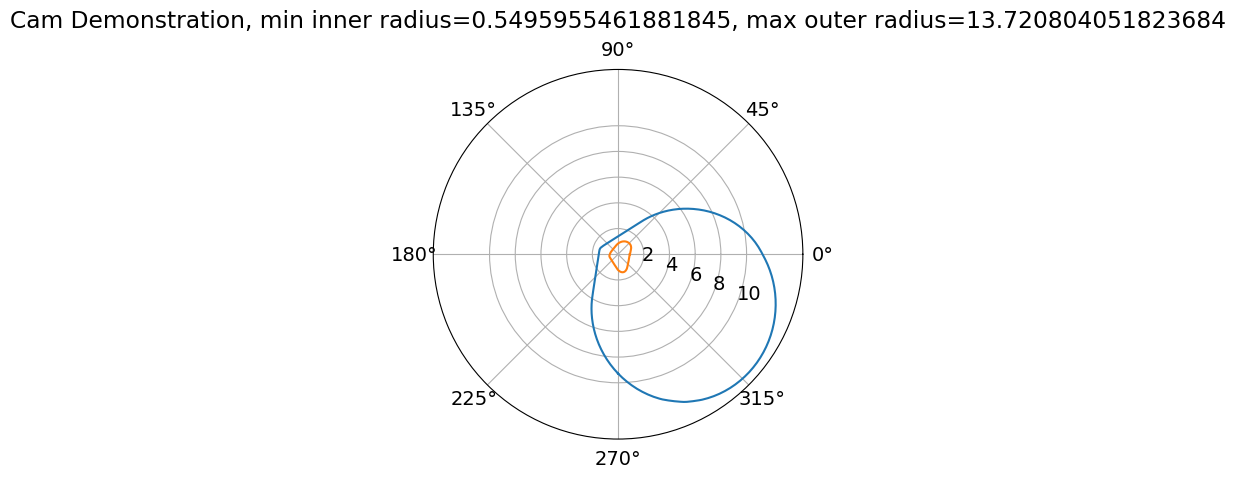

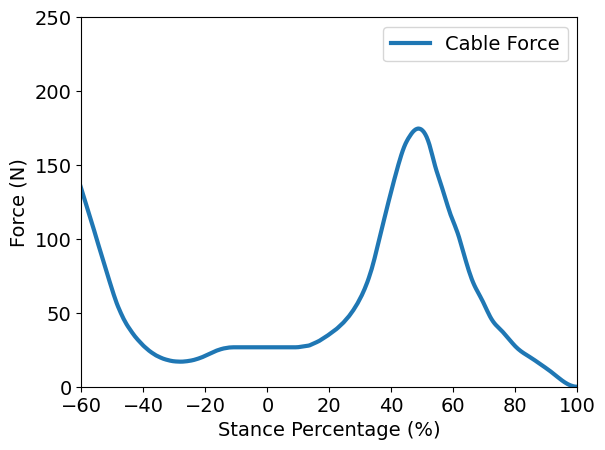

force at 32.3% =  70.94787223905875 ; max force of 174.6312373398316  at  48.63636363636363  %
max radii sum =  12.107138592592793
sitting force = 26.704712415849723
Max radius = 12.107138592592793, max_force_perc - 32.5 = 16.136363636363633, max_force_diff = 0.368762660168386, sitting_force = 26.704712415849723
TOTAL ERROR =  55.316977304974536
----------------------------------END----------------------------------
New solution! This is index 12!


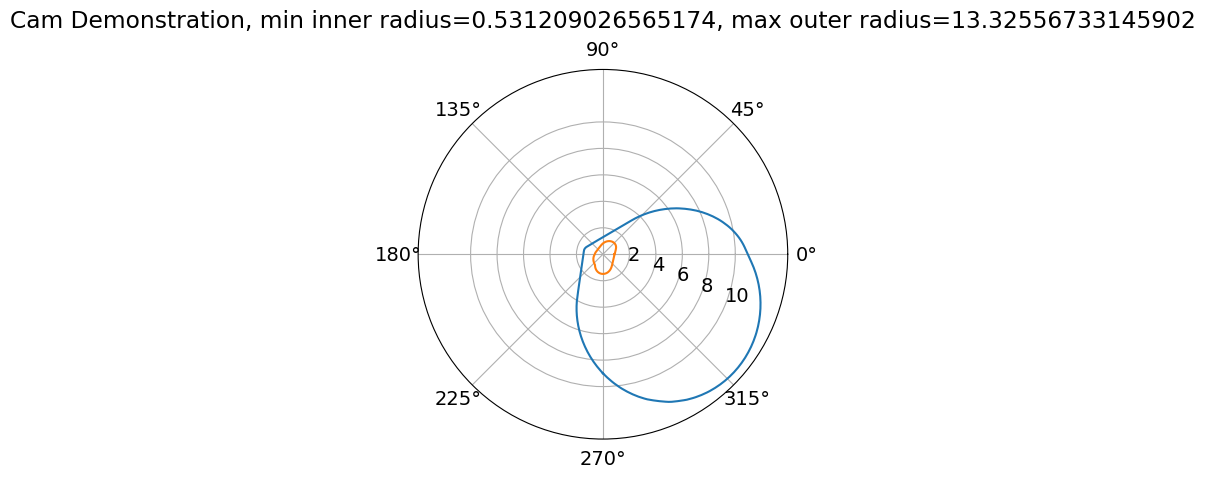

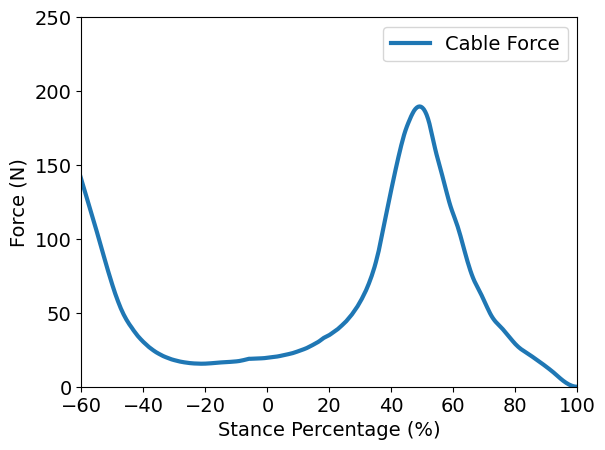

force at 32.3% =  67.49242746867712 ; max force of 189.5804452124512  at  49.090909090909086  %
max radii sum =  11.167753559522493
sitting force = 19.58497192580313
Max radius = 11.167753559522493, max_force_perc - 32.5 = 16.590909090909086, max_force_diff = 14.580445212451195, sitting_force = 19.58497192580313
TOTAL ERROR =  61.92407978868591
----------------------------------END----------------------------------
New solution! This is index 15!


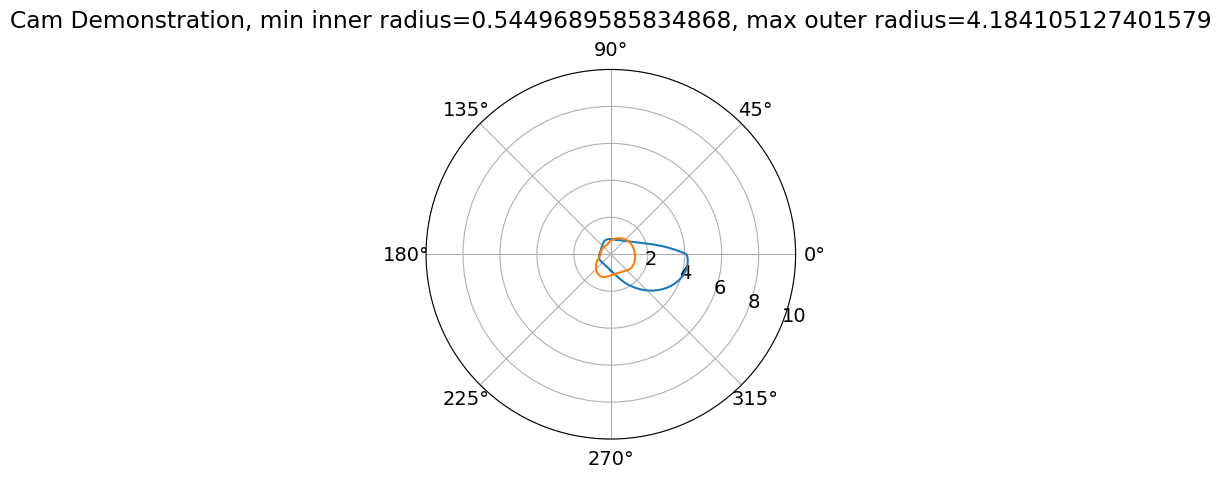

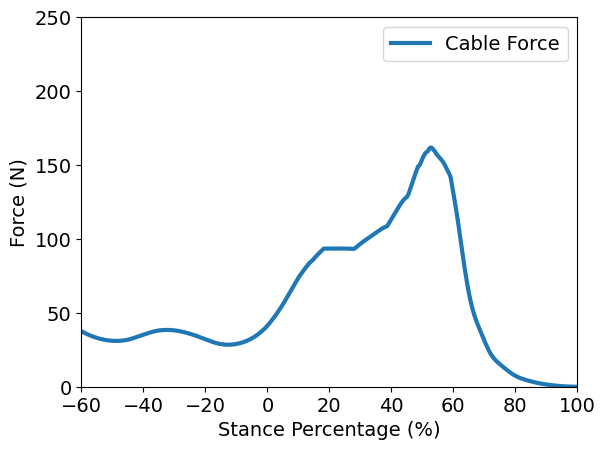

force at 32.3% =  100.16922468140721 ; max force of 161.85420534823544  at  52.72727272727273  %
max radii sum =  3.025262389785629
sitting force = 41.281748566216066
Max radius = 3.025262389785629, max_force_perc - 32.5 = 20.227272727272727, max_force_diff = 13.145794651764561, sitting_force = 41.281748566216066
TOTAL ERROR =  77.68007833503898
----------------------------------END----------------------------------
New solution! This is index 37!


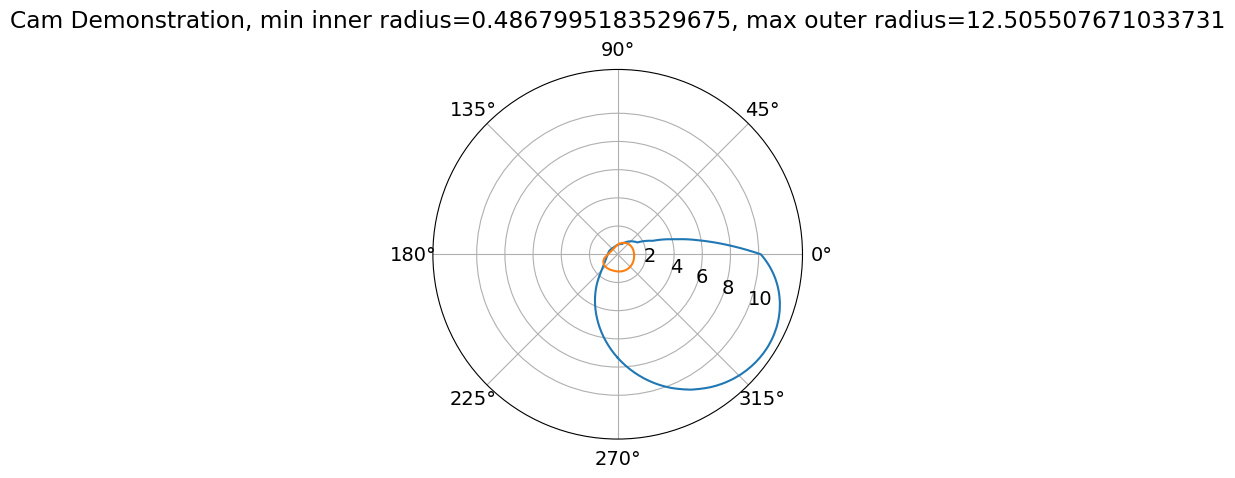

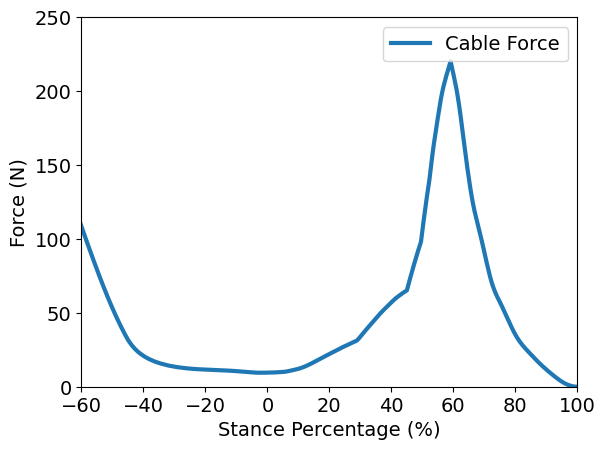

force at 32.3% =  39.67642910872549 ; max force of 220.11756653396318  at  59.090909090909086  %
max radii sum =  8.760765311391172
sitting force = 9.520783609560876
Max radius = 8.760765311391172, max_force_perc - 32.5 = 26.590909090909086, max_force_diff = 45.117566533963185, sitting_force = 9.520783609560876
TOTAL ERROR =  89.99002454582433
----------------------------------END----------------------------------
New solution! This is index 49!


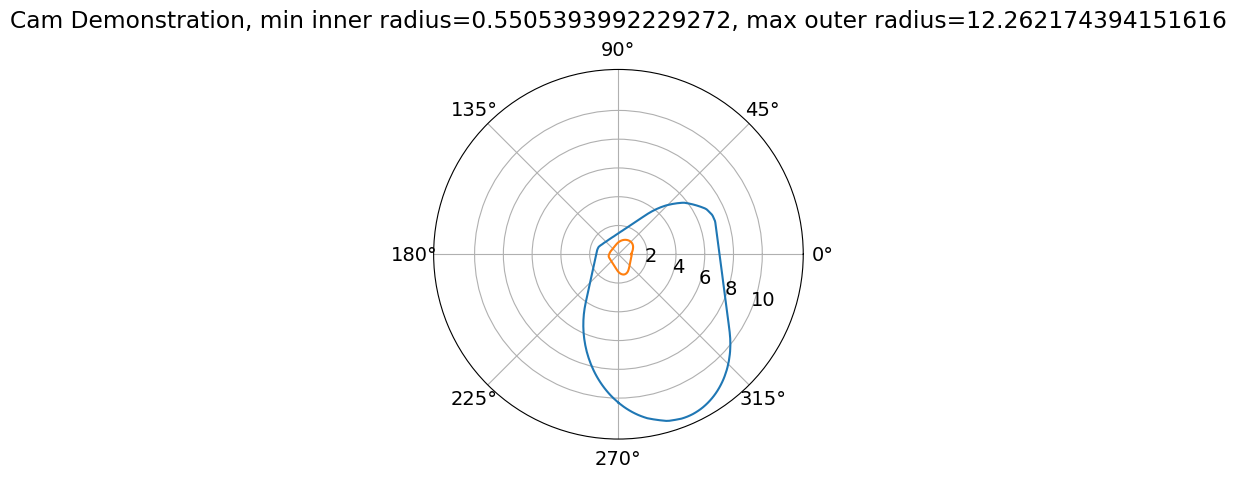

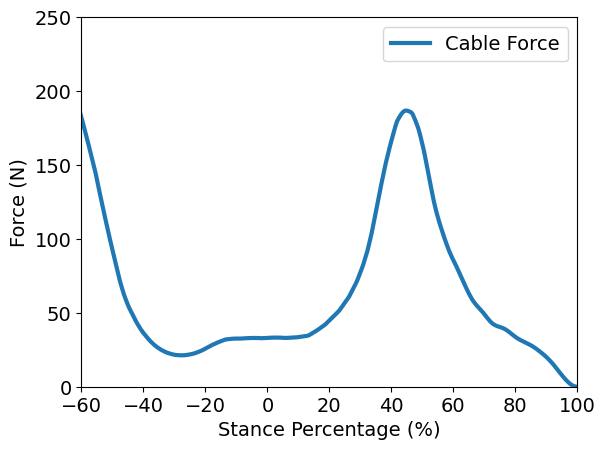

force at 32.3% =  91.99192427697686 ; max force of 186.78929706033338  at  44.54545454545455  %
max radii sum =  10.790483851808142
sitting force = 32.98786839289871
Max radius = 10.790483851808142, max_force_perc - 32.5 = 12.045454545454547, max_force_diff = 11.789297060333382, sitting_force = 32.98786839289871
TOTAL ERROR =  67.61310385049478
----------------------------------END----------------------------------


In [16]:
if len(results.X) <10:
    print("Less than 10 results!")
    for sub_x in results.X:
        gear_ratios = sub_x[:-1]
        initial_gr = sub_x[-1]
        gear_ratios = np.hstack((gear_ratios,gear_percentages))
        gear_ratios= gear_ratios.reshape((2,-1))
        gear_ratios[1, :] = 2 * np.pi * gear_ratios[1, :]
        Cam = CamGeneration(gear_ratios.T, initial_gr, sit_angle = np.pi * 220 / 180)
        R_plus_r = Cam.calculate_cam_radii()
        filename = 'data/Knee-angle_Chugo_2006.csv'
        inner_pts, outer_pts = Cam.cam_pts(stroke=0.1)
        forces,percentages = Cam.plot_forces_percentage(filename, torque = False, stroke = 0.1,plot=True)
else:
    print(f'There are {len(X)} results in the pareto front!')
    objective_limit = 50
    for i,sub_x in enumerate(X):
        in_range_flag = True
        for res in F[i]:
            if res > objective_limit:
                in_range_flag = False
        if in_range_flag:
            print(f'New solution! This is index {i}!')
            gear_ratios = sub_x[:-1]
            initial_gr = sub_x[-1]
            gear_ratios = np.hstack((gear_ratios, gear_percentages))
            gear_ratios= gear_ratios.reshape((2, -1))
            gear_ratios[1, :] = 2 * np.pi * gear_ratios[1, :]
            Cam = CamGeneration(gear_ratios.T, initial_gr, sit_angle = np.pi * 220 / 180)
            max_radius = Cam.calculate_cam_radii()
            filename = 'data/Knee-angle_Chugo_2006.csv'
            inner_pts, outer_pts = Cam.cam_pts(stroke = 0.1)
            forces, percentages = Cam.plot_forces_percentage(filename, torque = False, stroke = 0.1,plot=True)
            ideal_perc_ind = np.where(np.round(percentages,1) == 32.3)[0][0]
            ideal_perc_force = forces[ideal_perc_ind]
            max_force = max(forces)
            max_force_perc = percentages[np.where(forces == max_force)[0][0]]
            sitting_perc_ind = np.where(np.round(percentages,1) == 0)[0][0]
            sitting_force = forces[sitting_perc_ind] 

            # print("Force value at 32.3% is: ", ideal_perc_force)
            print('force at 32.3% = ',ideal_perc_force, '; max force of', max_force,' at ',max_force_perc, ' %')
            print('max radii sum = ',max_radius)
            print(f'sitting force = {sitting_force}')
            print(f'Max radius = {F[i][0]}, max_force_perc - 32.5 = {F[i][1]}, max_force_diff = {F[i][2]}, sitting_force = {F[i][3]}')
            print('TOTAL ERROR = ', F[i][0]+F[i][1]+F[i][2]+F[i][3])
            print('----------------------------------END----------------------------------')

In [17]:

df_dict = {'Size':F[:,0],'ideal_m_f_perc_diff':F[:,1],'ideal_max_force_diff':F[:,2],'sitting_force':F[:,3]}
df = pd.DataFrame(data=df_dict)
fig = px.scatter_3d(df, x='ideal_m_f_perc_diff', y='ideal_max_force_diff', z='sitting_force',
              color='Size')
fig.show()

# fig = plt.figure(figsize=(15, 15))
# ax = fig.add_subplot(projection='3d')
# p = ax.scatter(F[:,1], F[:,2], F[:,3],c=F[:,0])
# fig.colorbar(p)
